# Содержание


- [Предварительная обработка данных](#1)
    - [Импорт набора данных](#11)
    - [Поиск пропусков](#12)
    - [Поиск дубликатов](#13)
    - [Приведение типов данных](#14)
    - [Определение сбалансированности](#15)
    - [Поиск выбросов](#22)
- [Создание и обучение модели](#3)
    - [Подготовка данных для обучения](#31)
    - [Обучение моделей](#33)
        - [Ансамблевые модели: стекинг](#334)

# Создание и обучение модели <a id="3"></a>

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [39]:
df = pd.read_csv("cleaned_dataset.csv", index_col=0)

In [40]:
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,0,35,170,75,90.0,1.0,1.0,1,1,120,...,126,92,17.1,1,1.0,21,35,40,1,1
1,0,30,180,80,89.0,0.9,1.2,1,1,130,...,148,121,15.8,1,0.9,20,36,27,3,0
2,0,40,165,75,91.0,1.2,1.5,1,1,120,...,74,104,15.8,1,0.9,47,32,68,1,0
3,0,50,175,80,91.0,1.5,1.2,1,1,145,...,104,106,17.6,1,1.1,29,34,18,1,0
4,0,50,165,60,80.0,1.0,1.2,1,1,138,...,117,104,13.8,1,0.8,19,12,25,1,0


На этом шаге происходит обучение модели. Обучение моделей машинного обучения происходит итерационно - пробуются различные модели, перебираются гиперпараметры, сравниваются значения выбранной метрики и выбирается лучшая комбинация.


## Подготовка данных для обучения <a id="31"></a>

Вначале нужно определить, на каких данных будет обучаться модель, а на каких тестироваться. **Традиционный подход** - это разделение исходного набора данных на 3 части (обучение, валидация и тестирование) с пропорции 60/20/20. В данном случае обучающая выборка используется для обучения модели, а валидация и тестирование для получения значения метрики без эффекта переобучения.

Однако существует и другой подход к разбиению данных - разделение на 2 части (обучение и тестирование) по правилу 80-20 (80% тренировочный, 20% тестовый). Зачастую данный метод применяется в тех случаях, когда отсутствует достаточное количество данных как в обучающем, так и в проверочном наборе.  

Перед тем как начать разбивать данные необходимо выделить из исходного набора данных целевую переменную (столбец `DRK_YN`) и сохранить её в отдельную переменную. Ниже приведён код разделения:

In [41]:
x = df.drop(columns=["DRK_YN"], axis=1)
y = df["DRK_YN"]

В ходе выполнения данной работы будет использован подход с разделением исходной выборки на 2 части с пропорцией 80-20, поскольку данный способ является самым популярным способом разбиения данных. Для того, чтобы разбить данные таким образом, существует специальный метод `train_test_split` в библиотеке `scikit-learn`.

In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

### Ансамблевые модели: беггинг <a id="335"></a>

У каждой модели машинного обучения есть некоторый предел, до которого можно повышать точность, а дальше начинается переобучение и модель уже физически не может предсказать точнее, чем заложено в её природе. Эта природа определяется не только моделью, а связкой модели, т.е. математическим аппаратом и данными, которые эта модель пытается преобразовать. Однако точность работы одной конкретной модели не является пределом при решении задач машинного обучения.

Когда с этим столкнулись первые исследователи они обратились к математической статистике и выяснили, что если взять несколько однородных моделей и среднее их предсказание, но при этом модели обучены на немного разных выборках, то получится, что ошибка среднего равна $\sqrt{n}$, где $n$ это количество моделей. И ошибка выходит меньше за счёт того, что мы берём несколько одинаковых моделей. **Цель** ансамблевых методов - объединить различные классификаторы в метаклассификатор, который обладает лучшей эффективностью обобщения, чем каждый индивидуальный классификатор сам по себе.

В качестве примера ансамблей можно привести феномен "Мудрость толпы". В 1906 году Френсис Гальтон предлагал посетителям ярмарки угадать вес живого быка. Всего в эксперименте приняли участие около 800 человек. Каждый из участников должен был написать свой ответ на карточке и передать её Гальтону. Затем он сложил все ответы и разделил их на общее количество участников, чтобы получить среднее значение. Результат оказался удивительным: среднее значение всех ответов было ближе к истинному весу быка, чем большинство индивидуальных ответов.

Наиболее популярными видами ансамблирования являются:
1. **Бэггинг** (bagging: bootstrap aggregation) - принцип построения композиции, основанный на простом голосовании.
2. **Бустинг** - принцип построения композиции, основанный на последовательном обучении моделей, при котором модели исправляют ошибки друг у друга.
3. **Стекинг** - принцип, при котором происходит комбинация разнородных моделей для построения прогноза.

Последний из видом ансаблирования - **стекинг**. Стекинг представляет собой комбинацию разнородных моделей. Например, у нас есть логистическая регрессия, которую мы дополняем опорными векторами, затем добавляем случайный лес и так далее. Результаты базовых моделей объединяются в один с помощью обучаемой мета-модели.

При обучении мета-модели используется метод удерживаемого набора. Сначала набор данных разделяется на две части. Слабые ученики сначала обучаются на первой части, затем на второй. Затем создается новый обучающий набор на основе прогнозов, сделанных на прогнозах первой и второй части набора. Таким образом, на каждый образец из входного набора приходится столько прогнозов, сколько слабых учеников в ансамбле. В итоге, мета-модель учится прогнозировать значения на основе нового набора.

Работа этого типа ансамблей довольно проста. На вход всех слабых моделей подаётся обучающий набор, каждый прогноз идет к финальной модели, которая называется смеситель, после чего та вырабатывает финальный прогноз.

Перед началом импортируем все необходимые компоненты для обучения

In [51]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import chime
%load_ext chime 

The chime extension is already loaded. To reload it, use:
  %reload_ext chime


Далее, также как и в предыдущий раз, создадим конвейер, состоящий из стандартизатора и ансамбля моделей

In [58]:
# Создаем стандартизатор
standardizer = StandardScaler()

# Создаем классификатор - ансамбль моделей
estimators = [
    ('forest', RandomForestClassifier(n_jobs=-1, n_estimators=793, random_state=42, max_depth=14, max_features=12, min_samples_leaf=17)),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1))
]
stacked_model = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(min_samples_leaf=10))

# Создаем конвейер
pipe = Pipeline([("standardizer", standardizer), ("clf", stacked_model)])

Как и в предыдущие разы, определим гиперпараметры, от которых зависит классификатор и которые будут перебираться в процессе кросс-валидации:  

In [62]:
params = {
    'clf__lr__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__lr__C': np.arange(0.1, 5, 0.5),
    'clf__lr__l1_ratio': np.arange(0, 1, 0.2)
}

Запустим процесс кросс-валидации и выведем наилучшую комбинацию гиперпараметров для данного классификатора:

In [63]:
%%time
%%chime
stacked_classifier = HalvingGridSearchCV(
    estimator=pipe, 
    param_grid=params,
    factor=3,
    cv=5, verbose=1, 
    n_jobs=-3, 
    scoring="roc_auc",
    aggressive_elimination=True).fit(
    x_train, y_train
)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 9790
max_resources_: 793048
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 150
n_resources: 9790
Fitting 5 folds for each of 150 candidates, totalling 750 fits
----------
iter: 1
n_candidates: 50
n_resources: 29370
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 2
n_candidates: 17
n_resources: 88110
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 3
n_candidates: 6
n_resources: 264330
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 792990
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 6h 38min 59s
Wall time: 10h 8min 24s


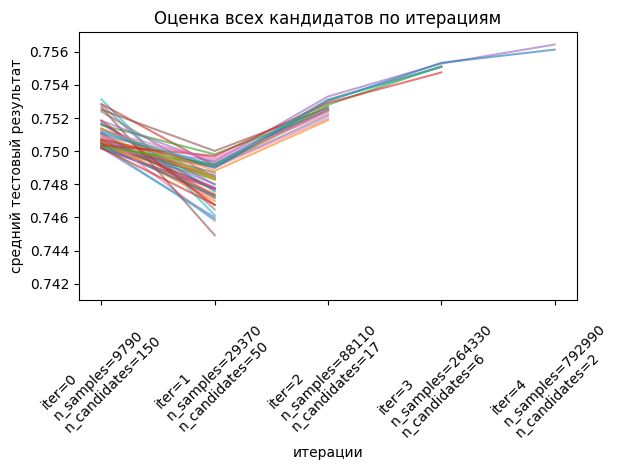

In [64]:
results = pd.DataFrame(stacked_classifier.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)
labels = [
    f"iter={i}\nn_samples={stacked_classifier.n_resources_[i]}\nn_candidates={stacked_classifier.n_candidates_[i]}"
    for i in range(stacked_classifier.n_iterations_)
]
ax.set_xticks(range(stacked_classifier.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Оценка всех кандидатов по итерациям")
ax.set_ylabel("средний тестовый результат")
ax.set_xlabel("итерации")
plt.tight_layout()
plt.show()

In [73]:
print('Оптимальные параметры:')
params = stacked_classifier.best_params_
for k in params:
    print(f"{k}: {params[k]}")
print(f'Наилучшая оценка: {stacked_classifier.best_score_:.2%}')

Оптимальные параметры:
clf__lr__C: 1.6
clf__lr__l1_ratio: 0.6000000000000001
clf__lr__penalty: elasticnet
Наилучшая оценка: 75.64%
